In [ ]:
import json
import os
import sys
from tqdm import tqdm

def load_jsonl_to_memory(filepath, fraction=4):
    # Determine the total number of lines to calculate the size of the fraction
    with open(filepath, 'r', encoding='utf-8') as file:
        total_lines = sum(1 for _ in file)
    
    # Calculate the number of lines to process based on the fraction
    lines_to_process = total_lines // fraction
    
    # Preallocate the list with None values for the fraction of data
    data = [None] * lines_to_process
    
    with open(filepath, 'r', encoding='utf-8') as file:
        processed_lines = 0  # Keep track of how many lines have been processed
        for index, line in enumerate(tqdm(file, total=total_lines, desc="Processing")):
            if (index-1) % fraction == 0:  # Process only every fraction-th line
                # Parse the JSON content from the line and add it to the data list
                data[processed_lines] = json.loads(line)
                processed_lines += 1
                if processed_lines >= lines_to_process:
                    break  # Stop if we've processed the intended number of lines
    
    return data

data = load_jsonl_to_memory('/mnt/datassd/processed_file.jsonl')

101.48939514160156

2660482.2

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming 'data' is your list of dictionaries
titles = [item['title'] for item in data]
view_counts = np.array([item['view_count'] for item in data])

# Parameters for tokenization and padding
vocab_size = 10000  # Adjust based on your dataset
max_length = 100  # Adjust based on the length of your titles
padding_type = 'post'
trunc_type = 'post'

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(titles)

# Convert titles to sequences and pad them
sequences = tokenizer.texts_to_sequences(titles)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Split the data into training and testing sets
X_train, X_test, y_train_n, y_test_n = train_test_split(padded_sequences, view_counts, test_size=0.2, random_state=42)


# Convert to log scale for normal distribution of data
y_test = np.log(y_test_n)
y_test = np.where(y_test == -np.inf, 0, y_test)

y_train = np.log(y_train_n)
y_train = np.where(y_train == -np.inf, 0, y_train)

In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow"


import numpy as np
import keras
from keras import layers
import keras_nlp

vocab_size = 10000  # Adjust based on your vocabulary size
embedding_dim = 256
max_length = 100  # Adjust based on your titles' maximum length
num_heads = 8  # Number of attention heads in the Transformer encoder
intermediate_dim = 512  # Dimensionality of the encoder's intermediate (feed-forward) layer

# Define input layer
inputs = keras.Input(shape=(max_length,), dtype='int64')

# Token and position embedding layer
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size,
    sequence_length=max_length,
    embedding_dim=embedding_dim,
)
x = embedding_layer(inputs)

# Transformer encoder layer
encoder = keras_nlp.layers.TransformerEncoder(
    num_heads=num_heads,
    intermediate_dim=intermediate_dim,
    activation='relu',
    dropout=0.1,
)
x = encoder(x)

# Since we're working on a regression task, a GlobalMaxPooling1D layer is used to reduce the sequence dimension
x = layers.GlobalMaxPooling1D()(x)

# Additional dense layers for further processing
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1, activation='linear')(x)  # Linear activation for a regression task

# Compile the model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

model.summary()

Using TensorFlow backend
---------------------------------------------------------------------------
ImportError                               Traceback (most recent call last)
Cell In[5], line 7
      5 import keras
      6 from keras import layers
----> 7 import keras_nlp
      9 vocab_size = 10000  # Adjust based on your vocabulary size
     10 embedding_dim = 256

File ~/.local/lib/python3.11/site-packages/keras_nlp/__init__.py:8
      1 """DO NOT EDIT.
      2 
      3 This file was autogenerated. Do not edit it by hand,
      4 since your modifications would be overwritten.
      5 """
----> 8 from keras_nlp import layers
      9 from keras_nlp import metrics
     10 from keras_nlp import models

File ~/.local/lib/python3.11/site-packages/keras_nlp/layers/__init__.py:8
      1 """DO NOT EDIT.
      2 
      3 This file was autogenerated. Do not edit it by hand,
      4 since your modifications would be overwritten.
      5 """
----> 8 from keras_nlp.src.layers.modeling.alibi_bias

In [ ]:
del data

import tensorflow as tf
import keras
#del X_train, y_train

model = tf.keras.models.load_model('YT_T30_log.keras')

In [4]:
# Assuming X_train, y_train are your training data and labels, respectively
model.fit(X_train, y_train, validation_split=0.1, epochs=15, batch_size=32)


[vim-jukit] Output not saved (output-json was over max size)


In [ ]:
model.save('YT_T45_log.keras')

In [5]:
# Predict view counts for the test set
predictions = model.predict(X_test, verbose=1)

# Optionally, compare the first few predictions to the actual view counts
for i in range(10):  # Display first 10 predictions
    print(f"Predicted view count: {predictions[i]}, Actual view count: {y_test[i]}")

16629/16629 [==============================] - 43s 3ms/step
Predicted view count: [7.3562193], Actual view count: 10.276360596043633
Predicted view count: [8.364229], Actual view count: 7.961370201719511
Predicted view count: [7.765519], Actual view count: 8.786609455061125
Predicted view count: [5.79698], Actual view count: 5.863631175598097
Predicted view count: [9.0218315], Actual view count: 9.342595951096653
Predicted view count: [7.5329237], Actual view count: 12.922926587034752
Predicted view count: [7.0577555], Actual view count: 7.2078598714324755
Predicted view count: [6.937106], Actual view count: 10.95159570903047
Predicted view count: [6.141575], Actual view count: 2.1972245773362196
Predicted view count: [8.862115], Actual view count: 6.192362489474872


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


heatmap, xedges, yedges = np.histogram2d(y_test.flatten(), predictions.flatten(), bins=50)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.savefig('t45_logh.png')

---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
Cell In[10], line 3
      1 import matplotlib.pyplot as plt
----> 3 plt.hexbin(y_test, predictions, gridsize=30)
      4 plt.savefig('t30_logh.png')

File ~/.local/lib/python3.11/site-packages/matplotlib/pyplot.py:2627, in hexbin(x, y, C, gridsize, bins, xscale, yscale, extent, cmap, norm, vmin, vmax, alpha, linewidths, edgecolors, reduce_C_function, mincnt, marginals, data, **kwargs)
   2620 @_copy_docstring_and_deprecators(Axes.hexbin)
   2621 def hexbin(
   2622         x, y, C=None, gridsize=100, bins=None, xscale='linear',
   (...)
   2625         reduce_C_function=np.mean, mincnt=None, marginals=False, *,
   2626         data=None, **kwargs):
-> 2627     __ret = gca().hexbin(
   2628         x, y, C=C, gridsize=gridsize, bins=bins, xscale=xscale,
   2629         yscale=yscale, extent=extent, cmap=cmap, norm=norm, vmin=vmin,
   263

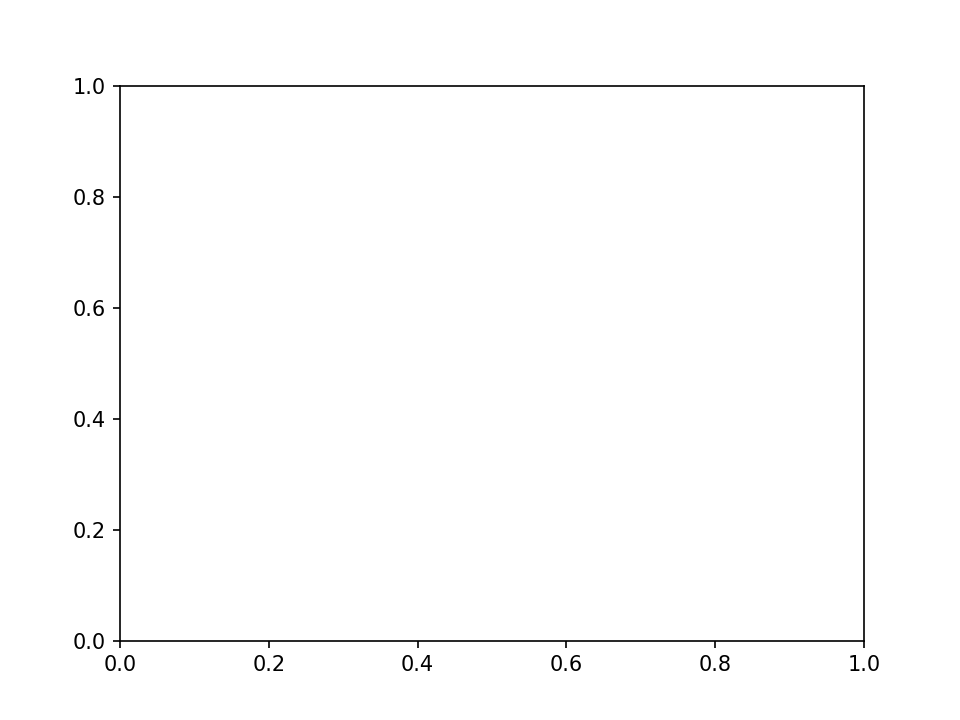

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(y_test, predictions, alpha=0.4)
plt.xlabel('Actual View Count')
plt.ylabel('Predicted View Count')
plt.savefig('t45_log.png')